In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

from best.pomdp import POMDP, POMDPNetwork

### Define two label MDPs

In [2]:
T0 = np.eye(3)
T1 = np.array([[0,0.5,0.5], [0,1,0], [0,0,1]])

def output_fcn(n):
    if n == 0:
        return 'init'    # label unknown
    if n == 1:
        return 'safe'    # can traverse region
    if n == 2:
        return 'unsafe'  # can not traverse region
    
map1 = POMDP([T0, T1], input_names=['meas1'],
             output_fcn=output_fcn, state_name='label1')

map2 = POMDP([T0, T1], input_names=['meas2'],
             output_fcn=output_fcn, state_name='label2')

print(map1)
print(map2)

MDP: (2,) inputs ('meas1',) --> 3 states label1 --> 3 outputs label1
MDP: (2,) inputs ('meas2',) --> 3 states label2 --> 3 outputs label2


### Define gridworld system MDP

In [3]:
# gridworld mdp
l_x = 4  # x length
l_y = 2  # y length

T_start = [np.ravel_multi_index( (i,j), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]

# north
Tn_end =   [np.ravel_multi_index( (i, max(0, j-1)), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]
# south
Ts_end =   [np.ravel_multi_index( (i, min(l_y-1, j+1)), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]
# east
Te_end =   [np.ravel_multi_index( (min(l_x-1, i+1), j), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]
# west
Tw_end =   [np.ravel_multi_index( (max(0, i-1), j), (l_x, l_y)) for i in range(l_x) for j in range(l_y)]

Tn = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Tn_end)), shape=(l_x*l_y, l_x*l_y))
Ts = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Ts_end)), shape=(l_x*l_y, l_x*l_y))
Te = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Te_end)), shape=(l_x*l_y, l_x*l_y))
Tw = sp.coo_matrix((np.ones(l_x*l_y), (T_start, Tw_end)), shape=(l_x*l_y, l_x*l_y))

def syst_input_fcn(m):
    if m == 'n':
        return 0
    elif m == 's':
        return 1
    elif m == 'e':
        return 2
    else:
        return 3

syst_mdp = POMDP([Tn, Ts, Te, Tw], input_fcns=[syst_input_fcn], input_names=['dir'], state_name='s')

print(syst_mdp)

MDP: (4,) inputs ('dir',) --> 8 states s --> 8 outputs s


### Connect system and labels

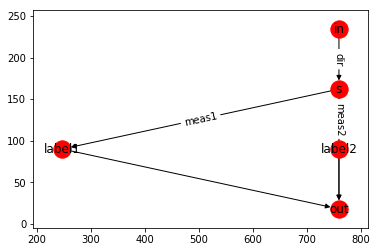

MDP network: (4,) inputs ('dir',), (8, 3, 3) states ('s', 'label1', 'label2'), (8, 3, 3) outputs ('s', 'label1', 'label2')


In [4]:
# define mappings s -> meas1 and s -> meas2
network = POMDPNetwork([syst_mdp, map1, map2])
network.add_connection('s', 'meas1', lambda s: set([1]) if s == 2 else set([0]))
network.add_connection('s', 'meas2', lambda s: set([1]) if s == 3 else set([0]))

network.plot()
plt.show()
print(network)

### Solve LTL problem on product system

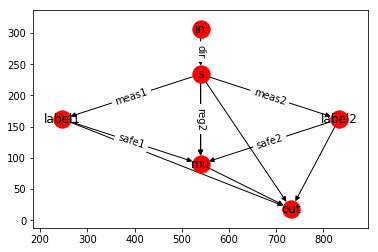

MDP network: (4,) inputs ('dir',), (8, 3, 3, 3) states ('s', 'label1', 'label2', 'mu'), (8, 3, 3, 3) outputs ('s', 'label1', 'label2', 'mu')
finished after 0.01945662498474121s and 5 iterations


In [5]:
from best.ltl import formula_to_pomdp
from best.val_iter import *

formula = '( ( ( !reg1 ) | safe1 ) & ( ( !reg2 ) | safe2 ) ) U target'

dfsa, dfsa_init, dfsa_final, proplist = formula_to_pomdp(formula)

network.add_pomdp(dfsa)

network.add_connection('s', 'target', lambda s: (1,) if s==6 else (0,))
network.add_connection('s', 'reg1', lambda s: (1,) if s==4 else (0,))
network.add_connection('s', 'reg2', lambda s: (1,) if s==5 else (0,))

network.add_connection('label1', 'safe1', lambda label1: (1,) if label1=='safe' else (0,))
network.add_connection('label2', 'safe2', lambda label2: (1,) if label2=='safe' else (0,))

network.plot()
plt.show()
print(network)

Vacc = np.zeros(network.N)
Vacc[..., list(dfsa_final)[0]] = 1

val = solve_reach(network, Vacc, delta=0.01)

### Simple simulation (p=0.75 of success)

In [9]:
# np.random.seed(4)  # fail
np.random.seed(3)  # long path

state = [0, 0, 0, list(dfsa_init)[0]]

p = 1

while not state[3] == list(dfsa_final)[0] and p > 0:
    print ("current state ", network.output(state))
  
    # get input
    u, p = get_input(network, state, val[0])
    print ("input ", u, "probability of sat ", p)

    # simulate
    state = network.evolve(state, u)
    print ("moved to ", network.output(state))
        
    print ()


current state  (0, 'init', 'init', 0)
input  (2,) probability of sat  0.7275
moved to  (2, 'unsafe', 'init', 0)

current state  (2, 'unsafe', 'init', 0)
input  (1,) probability of sat  0.485
moved to  (3, 'unsafe', 'safe', 0)

current state  (3, 'unsafe', 'safe', 0)
input  (2,) probability of sat  0.98
moved to  (5, 'unsafe', 'safe', 0)

current state  (5, 'unsafe', 'safe', 0)
input  (2,) probability of sat  0.99
moved to  (7, 'unsafe', 'safe', 0)

current state  (7, 'unsafe', 'safe', 0)
input  (0,) probability of sat  1.0
moved to  (6, 'unsafe', 'safe', 1)

